In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utilities.preprocessors import column_summary 
from utilities.visualizers import disp_cat_feat, view_feat_outliers

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read dataset
find the dataset here: https://www.kaggle.com/datasets/irakozekelly/u-s-chronic-disease-indicators-2023-release?resource=download

In [4]:
df = pd.read_csv('./data/U.S._Chronic_Disease_Indicators__CDI___2023_Release.csv')
df

C:\Users\LARRY\AppData\Local\Temp\ipykernel_11860\1820308279.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/U.S._Chronic_Disease_Indicators__CDI___2023_Release.csv')


,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2014,2014,AR,Arkansas,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,5,AST,AST3_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
1,2018,2018,CO,Colorado,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,8,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
2,2018,2018,DC,District of Columbia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,11,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2017,2017,GA,Georgia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,13,AST,AST3_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
4,2010,2010,MI,Michigan,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,26,AST,AST3_1,NMBR,RACE,HIS,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185671,2020,2020,WY,Wyoming,BRFSS,Diabetes,Dilated eye examination among adults aged >= 1...,NaN,%,Age-adjusted Prevalence,...,56,DIA,DIA7_0,AGEADJPREV,RACE,WHT,NaN,NaN,NaN,NaN
1185672,2020,2020,WY,Wyoming,BRFSS,Older Adults,Proportion of older adults aged >= 65 years wh...,NaN,%,Crude Prevalence,...,56,OLD,OLD3_1,CRDPREV,RACE,WHT,NaN,NaN,NaN,NaN
1185673,2017,2017,IA,Iowa,BRFSS,Arthritis,Activity limitation due to arthritis among adu...,NaN,%,Age-adjusted Prevalence,...,19,ART,ART2_1,AGEADJPREV,RACE,HIS,NaN,NaN,NaN,NaN
1185674,2020,2020,WY,Wyoming,BRFSS,Diabetes,Diabetes prevalence among women aged 18-44 years,NaN,%,Crude Prevalence,...,56,DIA,DIA2_2,CRDPREV,RACE,HIS,NaN,NaN,NaN,NaN


In [5]:
column_summary(df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,YearStart,int64,0,1185676,16,"{2015: 126086, 2013: 118802, 2014: 116761, 201..."
1,YearEnd,int64,0,1185676,16,"{2015: 126086, 2017: 125300, 2013: 118802, 201..."
2,LocationAbbr,object,0,1185676,55,"{'WI': 22556, 'NY': 22556, 'NJ': 22550, 'NE': ..."
3,LocationDesc,object,0,1185676,55,"{'Wisconsin': 22556, 'New York': 22556, 'New J..."
4,DataSource,object,0,1185676,31,"{'BRFSS': 657205, 'NVSS': 175179, 'Death Certi..."
5,Topic,object,0,1185676,17,"{'Cancer': 176339, 'Cardiovascular Disease': 1..."
6,Question,object,0,1185676,203,{'Hospitalization for heart failure among Medi...
7,Response,float64,1185676,0,0,{}
8,DataValueUnit,object,152123,1033553,12,"{'%': 655776, 'cases per 100,000': 107789, 'pe..."
9,DataValueType,object,0,1185676,19,"{'Crude Prevalence': 370903, 'Age-adjusted Pre..."


In [6]:
num_cols = df.select_dtypes(include=[float, int]).columns
cat_cols = df.select_dtypes(include=[object, "datetime"]).columns

In [7]:
num_cols

Index(['YearStart', 'YearEnd', 'Response', 'DataValueAlt',
       'LowConfidenceLimit', 'HighConfidenceLimit', 'StratificationCategory2',
       'Stratification2', 'StratificationCategory3', 'Stratification3',
       'ResponseID', 'LocationID', 'StratificationCategoryID2',
       'StratificationID2', 'StratificationCategoryID3', 'StratificationID3'],
      dtype='object')

In [8]:
cat_cols

Index(['LocationAbbr', 'LocationDesc', 'DataSource', 'Topic', 'Question',
       'DataValueUnit', 'DataValueType', 'DataValue',
       'DataValueFootnoteSymbol', 'DatavalueFootnote',
       'StratificationCategory1', 'Stratification1', 'GeoLocation', 'TopicID',
       'QuestionID', 'DataValueTypeID', 'StratificationCategoryID1',
       'StratificationID1'],
      dtype='object')

In [9]:
cat_cols.shape

(18,)

#### first half of categorical columns

In [10]:
cat_cols[:cat_cols.shape[0] // 2].shape

(9,)

['#3DA78A', '#717CE3', '#078D8B', '#0ACFFD', '#3C5F7F', '#A44A2C', '#A73377', '#CA0224', '#745BF8', '#AB6D85'] 10
<BarContainer object of 10 artists>
LocationAbbr
['#89E621', '#7A11EB', '#E02D4E', '#657CAD', '#84DFEA', '#3BC3FB', '#631F7A', '#DB3502', '#D508AC', '#EF5C8A'] 10
<BarContainer object of 10 artists>
LocationDesc
['#A7C495', '#1215C3', '#7CBDA8', '#236743', '#E5D362', '#6A8CF0', '#49DC07', '#C06AFD', '#4D553A', '#383AFB'] 10
<BarContainer object of 10 artists>
DataSource
['#4D8ED8', '#C551B7', '#8CBDA6', '#3C952D', '#A3D56F', '#F2010D', '#25A718', '#0123AC', '#036960', '#0B5AEF'] 10
<BarContainer object of 10 artists>
Topic
['#1FC7E8', '#9BF8D9', '#C1C358', '#04EDAD', '#E045B7', '#2E2B55', '#166CA2', '#73E34E', '#8A2A46', '#973C47'] 10
<BarContainer object of 10 artists>
Question
['#2E534E', '#07E5F9', '#C3D5BB', '#C69CF5', '#652B01', '#A43423', '#6F23F3', '#B3A47B', '#94FCF5', '#BC519F'] 10
<BarContainer object of 10 artists>
DataValueUnit
['#A43DBC', '#A54585', '#F7E5F1', 

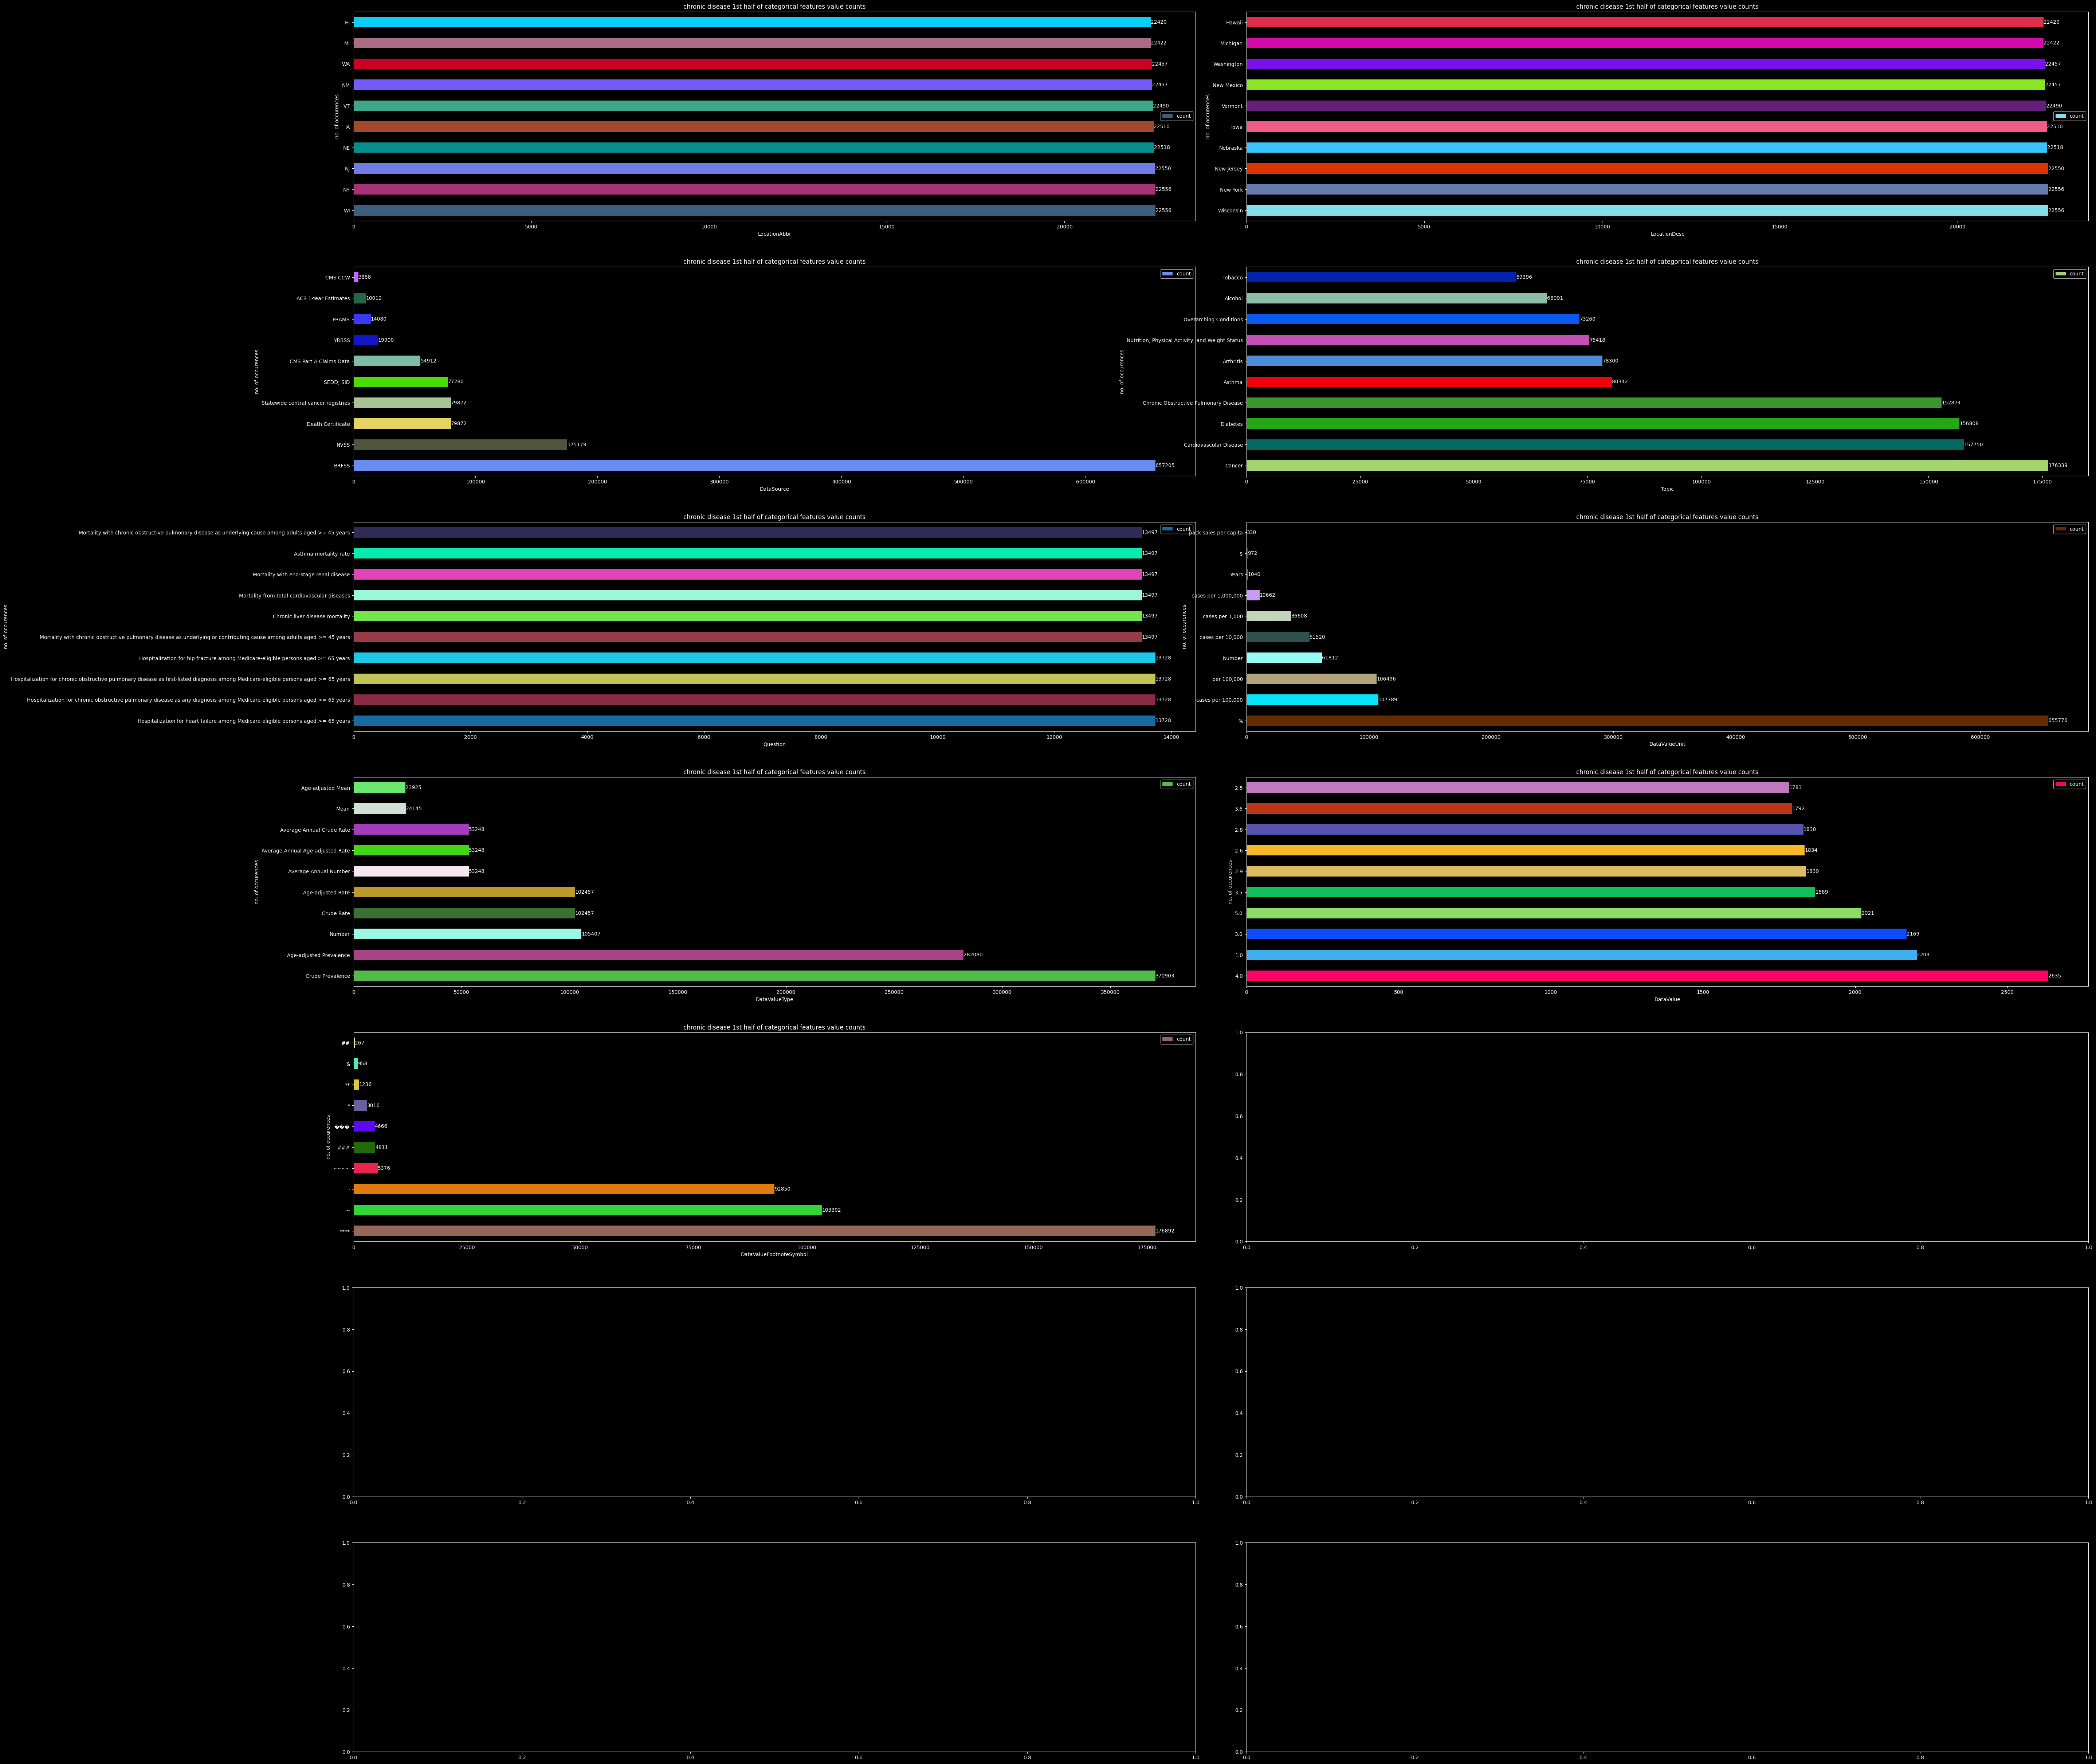

In [11]:
disp_cat_feat(df, cat_cols[:cat_cols.shape[0] // 2], fig_size=(50, 50), fig_dims=(7, 2), img_title="chronic disease 1st half of categorical features value counts")

#### second half of categorical columns

In [12]:
cat_cols[cat_cols.shape[0] // 2:].shape

(9,)

['#216C40', '#59985B', '#7B4F0D', '#1BC713', '#963829', '#2A4722', '#D4B8D6', '#562DA4', '#461F2B', '#67D3CE'] 10
<BarContainer object of 10 artists>
DatavalueFootnote
['#4CBD48', '#E290B3', '#E981DA'] 3
<BarContainer object of 3 artists>
StratificationCategory1
['#51D60D', '#12751A', '#BB2724', '#DA1160', '#C14A0C', '#97C2FC', '#0BE4A0', '#6232CC', '#E36DE6', '#E9AD87'] 10
<BarContainer object of 10 artists>
Stratification1
['#7E7181', '#8C1F8E', '#B8D2EE', '#903BCB', '#ACD14D', '#831F02', '#112F46', '#972B68', '#756430', '#0DB2DD'] 10
<BarContainer object of 10 artists>
GeoLocation
['#7DF1EA', '#81D939', '#2F1043', '#9CB010', '#9DAFA9', '#F8D219', '#7A2162', '#B8303E', '#3B6A5F', '#E95799'] 10
<BarContainer object of 10 artists>
TopicID
['#50EA5B', '#B6878F', '#382DC8', '#DA20FD', '#FD476F', '#44F07A', '#9C2841', '#67538F', '#BA3A58', '#2EA899'] 10
<BarContainer object of 10 artists>
QuestionID
['#DD929F', '#79C66B', '#B8FD6D', '#86AB2B', '#962BD4', '#681CFB', '#1110FC', '#EDF628', '

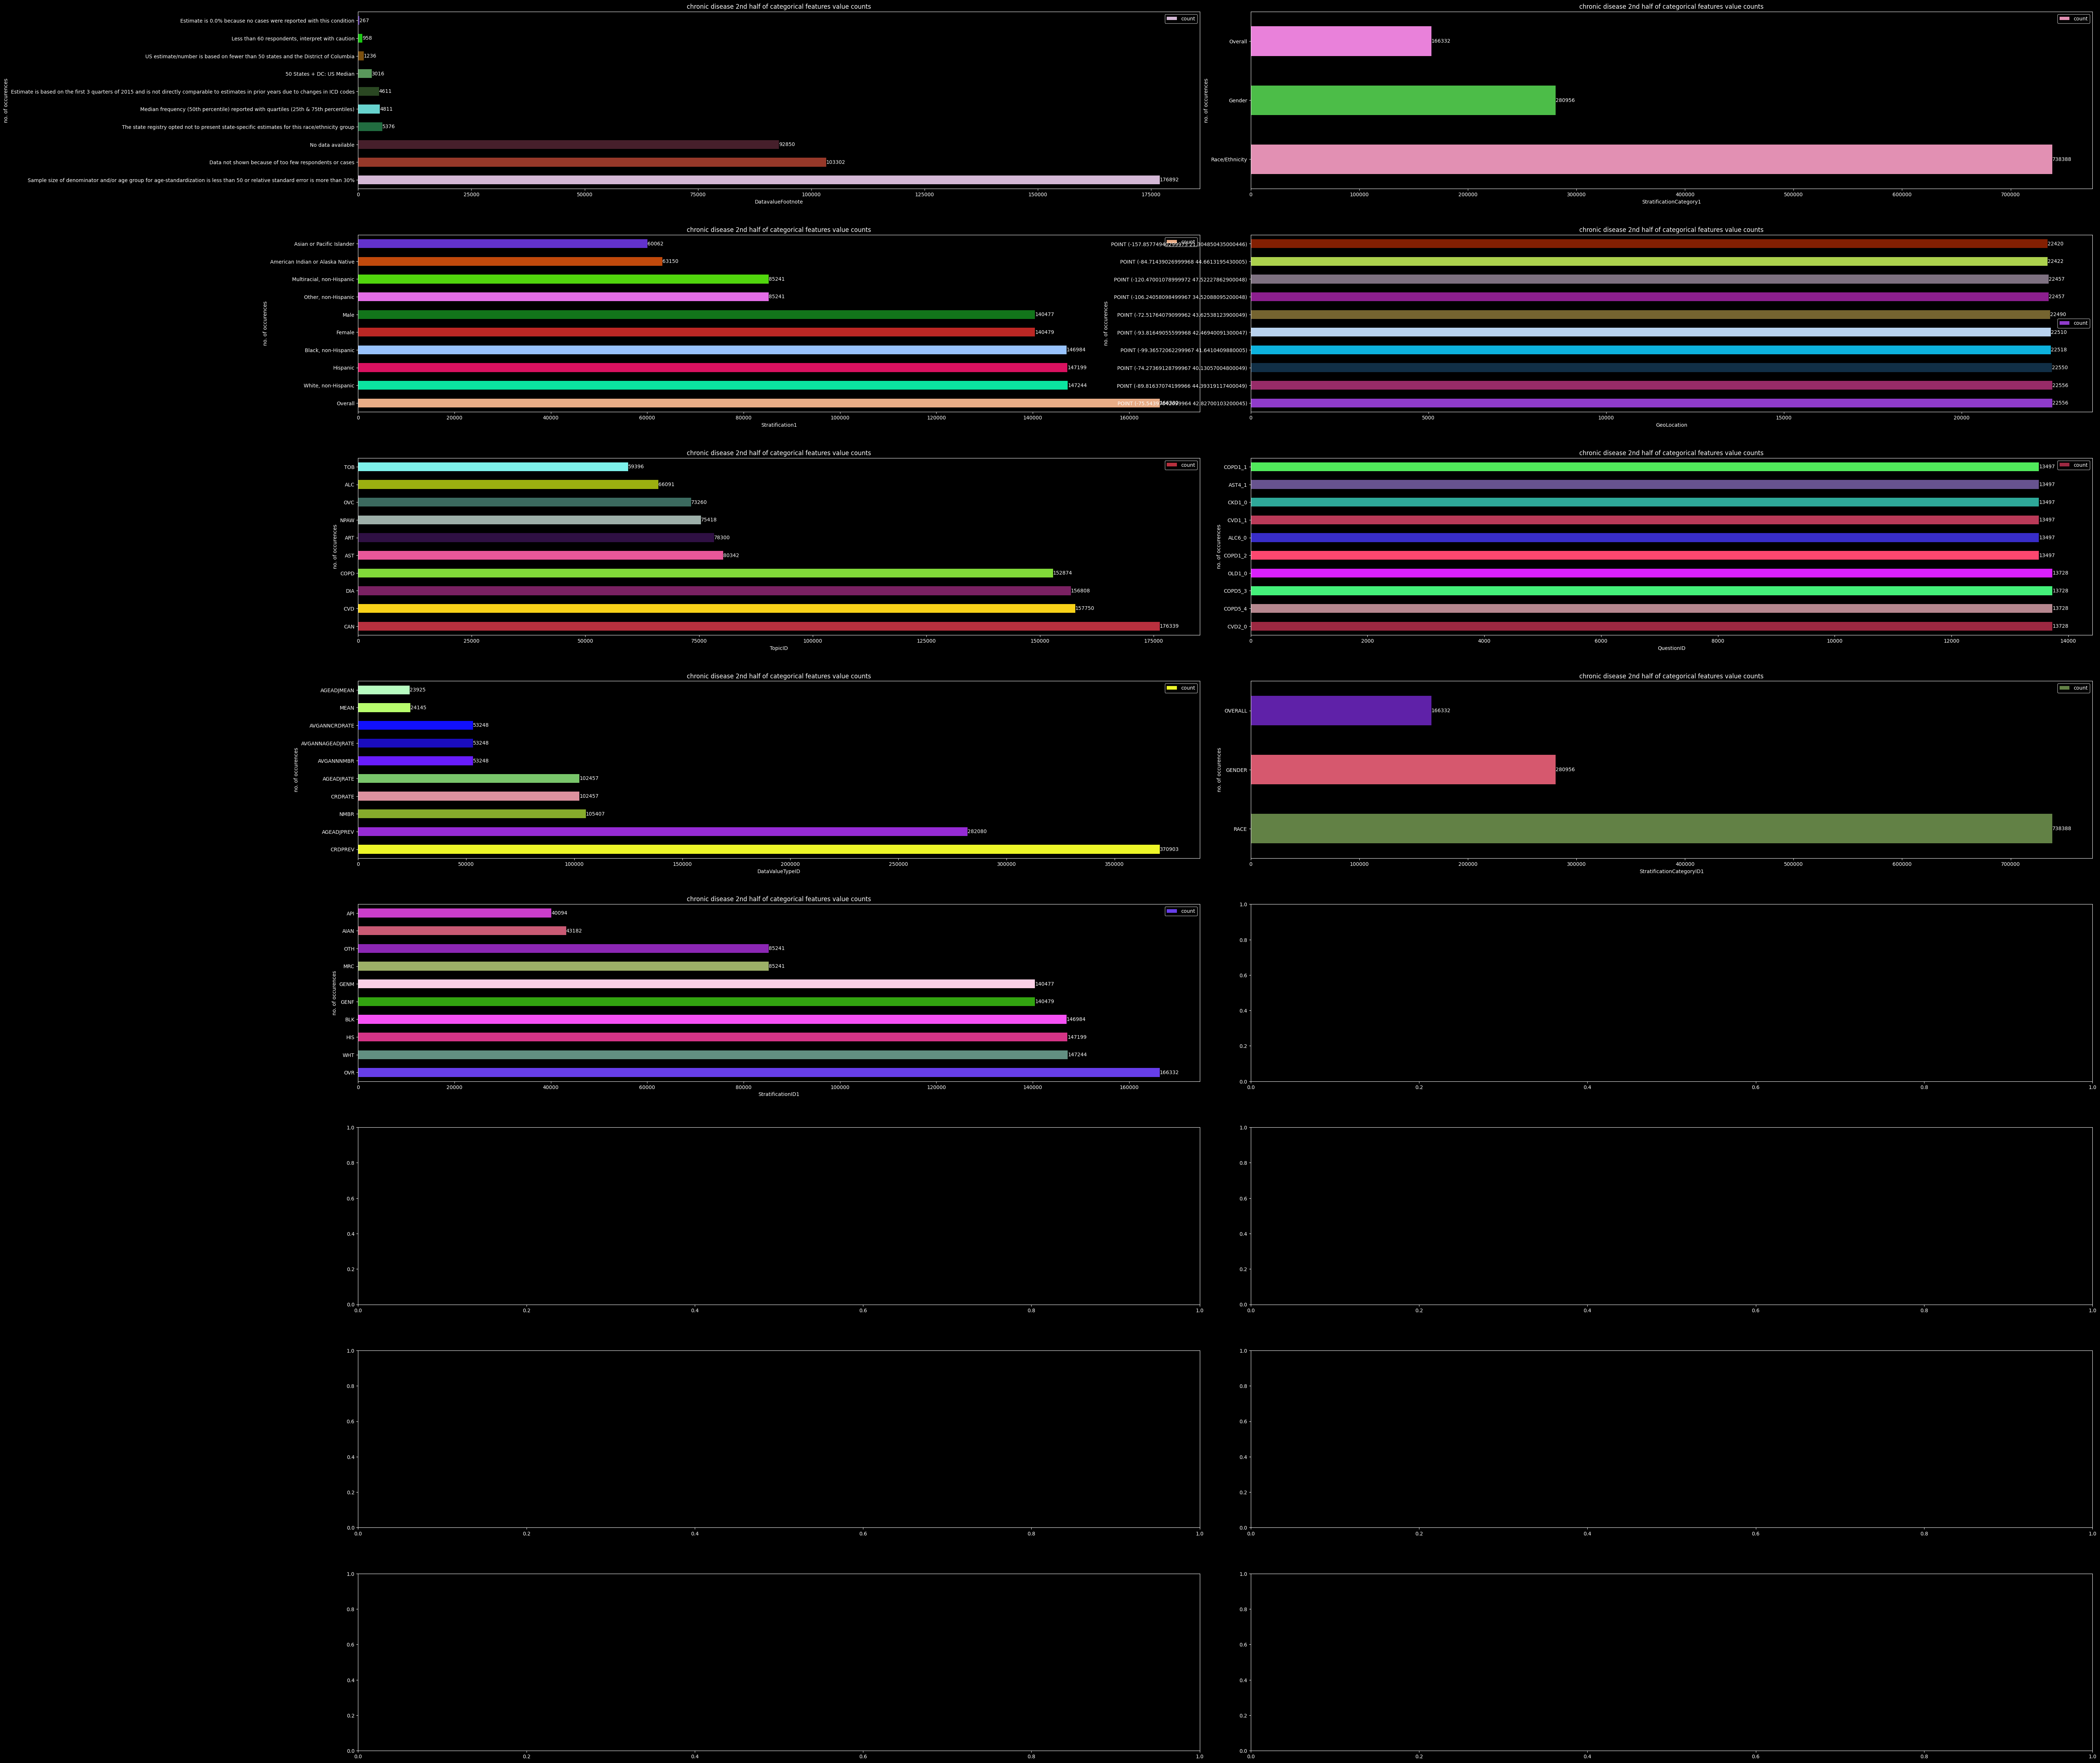

In [13]:
disp_cat_feat(df, cat_cols[cat_cols.shape[0] // 2:], fig_size=(50, 50), fig_dims=(8, 2), img_title="chronic disease 2nd half of categorical features value counts")

#### Useful columns seem to be `LocationAbbr`, `LocationDesc`, `Question`, `DataSource`, `Topic`, `Stratification1`, `StratificationCategory`, Geolocation

#### Useless columns seem to be `Response`, `DateValueFootnoteSymbol`, `DataValueFootnote`, `Stratification2`, `StratificationCategory2`, `Stratification3`, `StratificationCategory3`, `ResponseID`, `StratificationCategory1ID`, `StratificationID1`, `StratificationCategory2ID`, `StratificationID2`, `StratificationCategory3ID`, `StratificationID3`

#### Columns that could be removed but should be screened further seem to be `DataValueUnit`, `DataValueTypeID`, `DataValueType`, `DataValue`, `TopicID`, `QuestionID`, `LocationID`

In [14]:
df = df.drop(columns=["Response",
    "ResponseID",
    "DataValueFootnoteSymbol",
    "DatavalueFootnote",

    "StratificationCategory2",
    "Stratification2",
    "StratificationCategory3",
    "Stratification3",

    "StratificationCategoryID1",
    "StratificationID1",
    "StratificationCategoryID2",
    "StratificationID2",
    "StratificationCategoryID3",
    "StratificationID3"])
df = df.reset_index(drop=True)

In [15]:
df

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,GeoLocation,LocationID,TopicID,QuestionID,DataValueTypeID
0,2014,2014,AR,Arkansas,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,916,916.0,NaN,NaN,Gender,Male,POINT (-92.27449074299966 34.74865012400045),5,AST,AST3_1,NMBR
1,2018,2018,CO,Colorado,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,2227,2227.0,NaN,NaN,Overall,Overall,POINT (-106.13361092099967 38.843840757000464),8,AST,AST3_1,NMBR
2,2018,2018,DC,District of Columbia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,708,708.0,NaN,NaN,Overall,Overall,POINT (-77.036871 38.907192),11,AST,AST3_1,NMBR
3,2017,2017,GA,Georgia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,3520,3520.0,NaN,NaN,Gender,Female,POINT (-83.62758034599966 32.83968109300048),13,AST,AST3_1,NMBR
4,2010,2010,MI,Michigan,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,123,123.0,NaN,NaN,Race/Ethnicity,Hispanic,POINT (-84.71439026999968 44.6613195430005),26,AST,AST3_1,NMBR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185671,2020,2020,WY,Wyoming,BRFSS,Diabetes,Dilated eye examination among adults aged >= 1...,%,Age-adjusted Prevalence,NaN,NaN,NaN,NaN,Race/Ethnicity,"White, non-Hispanic",POINT (-108.10983035299967 43.23554134300048),56,DIA,DIA7_0,AGEADJPREV
1185672,2020,2020,WY,Wyoming,BRFSS,Older Adults,Proportion of older adults aged >= 65 years wh...,%,Crude Prevalence,41.5,41.5,38.5,44.6,Race/Ethnicity,"White, non-Hispanic",POINT (-108.10983035299967 43.23554134300048),56,OLD,OLD3_1,CRDPREV
1185673,2017,2017,IA,Iowa,BRFSS,Arthritis,Activity limitation due to arthritis among adu...,%,Age-adjusted Prevalence,NaN,NaN,NaN,NaN,Race/Ethnicity,Hispanic,POINT (-93.81649055599968 42.46940091300047),19,ART,ART2_1,AGEADJPREV
1185674,2020,2020,WY,Wyoming,BRFSS,Diabetes,Diabetes prevalence among women aged 18-44 years,%,Crude Prevalence,NaN,NaN,NaN,NaN,Race/Ethnicity,Hispanic,POINT (-108.10983035299967 43.23554134300048),56,DIA,DIA2_2,CRDPREV


#### `Geolocation` is still a tuple, why not separate it instead into latitude and longitude values

In [16]:
geo_loc = df.iloc[0]["GeoLocation"]
geo_loc

'POINT (-92.27449074299966 34.74865012400045)'

In [17]:
import re
import ast

In [18]:
test = re.sub(r"(POINT|[/(/)])", "", geo_loc)
test = test.strip()
test = test.split(" ")
latitude, longitude = ast.literal_eval(test[0]), ast.literal_eval(test[1]) 
latitude, longitude

(-92.27449074299966, 34.74865012400045)

In [19]:
def get_lat_long(geo_loc):
    
    if pd.isna(geo_loc):
        return (np.nan, np.nan)
    
    # if geoloc is not null or nan extract its
    # longitude and latitude 
    # print(geo_loc)
    test = re.sub(r"(POINT|[/(/)])", "", geo_loc)
    test = test.strip()
    test = test.split(" ")
    latitude, longitude = ast.literal_eval(test[0]), ast.literal_eval(test[1]) 
    
    return latitude, longitude

In [20]:
lat_longs = df["GeoLocation"].apply(get_lat_long).to_list()
lat_longs

[(-92.27449074299966, 34.74865012400045),
 (-106.13361092099967, 38.843840757000464),
 (-77.036871, 38.907192),
 (-83.62758034599966, 32.83968109300048),
 (-84.71439026999968, 44.6613195430005),
 (-109.42442064499971, 47.06652897200047),
 (-120.15503132599969, 44.56744942400047),
 (-66.590149, 18.220833),
 (-66.590149, 18.220833),
 (-89.81637074199966, 44.39319117400049),
 (-89.81637074199966, 44.39319117400049),
 (-86.63186076199969, 32.84057112200048),
 (-114.3637300419997, 43.682630005000476),
 (-114.3637300419997, 43.682630005000476),
 (-88.99771017799969, 40.48501028300046),
 (-98.20078122699965, 38.34774030000045),
 (-98.20078122699965, 38.34774030000045),
 (-98.20078122699965, 38.34774030000045),
 (-92.44568007099969, 31.31266064400046),
 (-72.08269067499964, 42.27687047000046),
 (-76.60926011099963, 39.29058096400047),
 (-76.60926011099963, 39.29058096400047),
 (-94.79420050299967, 46.35564873600049),
 (-89.53803082499968, 32.745510099000455),
 (-79.15925046299964, 35.466220975

In [21]:
df["Latitude"], df["Longitude"] = list(zip(*lat_longs))

#### We can already drop `GeoLocation` as we havee already extracted the `latitude` and `longitude` values from its tuple that way we don't get any sql rollback errors anymore as we won't have to push this tuple into a database which is a datatype that does not exist

In [22]:
df.drop(columns=["GeoLocation"], inplace=True)

#### We can also drop the `topicID`, `questionID`, and `locationID` columsn as these are now irrelevant to our analysis

In [23]:
df.drop(columns=["TopicID", "QuestionID", "LocationID"], inplace=True)

In [24]:
df.head(100)

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,DataValueTypeID,Latitude,Longitude
0,2014,2014,AR,Arkansas,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,916,916.0,NaN,NaN,Gender,Male,NMBR,-92.274491,34.748650
1,2018,2018,CO,Colorado,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,2227,2227.0,NaN,NaN,Overall,Overall,NMBR,-106.133611,38.843841
2,2018,2018,DC,District of Columbia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,708,708.0,NaN,NaN,Overall,Overall,NMBR,-77.036871,38.907192
3,2017,2017,GA,Georgia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,3520,3520.0,NaN,NaN,Gender,Female,NMBR,-83.627580,32.839681
4,2010,2010,MI,Michigan,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,123,123.0,NaN,NaN,Race/Ethnicity,Hispanic,NMBR,-84.714390,44.661320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2011,2015,CA,California,Death Certificate,Cancer,"Melanoma, mortality",NaN,Average Annual Number,638,638.0,NaN,NaN,Gender,Male,AVGANNNMBR,-121.000000,37.638640
96,2013,2017,CA,California,Death Certificate,Cancer,"Melanoma, mortality",NaN,Average Annual Number,608,608.0,NaN,NaN,Gender,Male,AVGANNNMBR,-121.000000,37.638640
97,2013,2017,CA,California,Death Certificate,Cancer,"Melanoma, mortality",NaN,Average Annual Number,896,896.0,NaN,NaN,Overall,Overall,AVGANNNMBR,-121.000000,37.638640
98,2011,2015,DC,District of Columbia,Death Certificate,Cancer,"Melanoma, mortality",NaN,Average Annual Number,3,3.0,NaN,NaN,Race/Ethnicity,"White, non-Hispanic",AVGANNNMBR,-77.036871,38.907192


####  Oh ok so the reason why the `topic`, `question`, `datavalueunit` and `datavalue`/`datavaluealt` columns are important is because for example the `topic` is `alchohol`, `question` is `alcohol use amoung youth?` (or more accurately what is the "count" of alcohol among youth), `datavalueunit` is `%`, and `datavalue` is `36.7` entails that *in the year 2013 in connecticut the alcohol use among youth was 36.7%*

In [25]:
df["DataValueUnit"].value_counts().index.to_list()[:10]

['%',
 'cases per 100,000',
 'per 100,000',
 'Number',
 'cases per 10,000',
 'cases per 1,000',
 'cases per 1,000,000',
 'Years',
 '$',
 'pack sales per capita']

In [26]:
df["DataValue"].value_counts().index.to_list()[:]

[4.0,
 1.0,
 3.0,
 5.0,
 3.5,
 2.9,
 2.6,
 2.8,
 3.6,
 2.5,
 2.7,
 3.4,
 3.1,
 3.7,
 7.0,
 4.1,
 3.8,
 3.3,
 3.2,
 3.9,
 6.0,
 2.4,
 4.2,
 2.3,
 4.4,
 4.3,
 8.0,
 2.2,
 1.1,
 4.5,
 2.1,
 4.6,
 1.6,
 'No',
 4.7,
 1.7,
 1.3,
 2.0,
 4.8,
 9.0,
 1.4,
 21.0,
 1.9,
 20.0,
 26.0,
 22.0,
 5.1,
 1.8,
 25.0,
 28.0,
 1.5,
 27.0,
 24.0,
 4.9,
 0.1,
 30.0,
 23.0,
 33.0,
 29.0,
 7.1,
 31.0,
 5.4,
 5.2,
 10.0,
 32.0,
 5.3,
 1.2,
 5.5,
 7.2,
 11.0,
 6.8,
 34.0,
 7.4,
 7.6,
 13.0,
 6.9,
 7.3,
 12.0,
 5.6,
 7.7,
 6.7,
 5.8,
 36.0,
 5.7,
 6.6,
 7.8,
 6.5,
 35.0,
 7.5,
 5.9,
 37.0,
 14.0,
 6.2,
 38.0,
 8.1,
 7.9,
 8.2,
 6.1,
 39.0,
 8.4,
 18.0,
 40.0,
 8.3,
 6.4,
 0.9,
 16.0,
 6.3,
 8.7,
 15.0,
 42.0,
 41.0,
 19.0,
 0.3,
 8.5,
 43.0,
 8.8,
 17.0,
 8.6,
 8.9,
 29.3,
 0.2,
 9.4,
 44.0,
 46.0,
 30.9,
 48.0,
 30.6,
 27.5,
 28.4,
 9.3,
 28.9,
 31.4,
 65.0,
 29.1,
 9.1,
 9.5,
 29.2,
 9.8,
 63.0,
 33.1,
 29.6,
 27.9,
 9.9,
 31.5,
 32.4,
 64.0,
 29.5,
 67.0,
 66.0,
 26.5,
 26.3,
 47.0,
 28.7,
 30.8,
 29.4,
 9.7,


In [27]:
df["DataValueAlt"].value_counts().index.to_list()[:10]

[4.0, 1.0, 3.0, 5.0, 3.5, 2.6, 2.8, 2.9, 2.5, 3.6]

#### Sometimes however these key columns like `datavalueunit` and `datavalue`/`datavaluealt` maybe null and so sometimes we may not need to include rows with columns that have these null values. Moreover `datavalue` has some values which are not null but instead are empty strings; these should be considered null and so cleaning the dataframe to fill in these empty strings with null values instead should be done and then convert this column to a float instead

In [28]:
def str_to_float(data_value):
    """
    converts string values of a column with "", "no"
    into nan values and string floats to real float
    values e.g. '1.4' to 1.4
    """
    try:
        return float(data_value)

    except:
        return np.nan

In [29]:
df["DataValue"] = df["DataValue"].apply(str_to_float)

In [30]:
df["DataValue"].isna().sum()

np.int64(381098)

In [31]:
df["DataValueAlt"].isna().sum()

np.int64(381098)

In [32]:
df[~df["DataValue"].isna() | ~df["DataValueAlt"].isna()].sample(n=5)

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,DataValueTypeID,Latitude,Longitude
762121,2012,2012,LA,Louisiana,BRFSS,Arthritis,Arthritis among adults aged >= 18 years who ar...,%,Age-adjusted Prevalence,28.2,28.2,25.0,31.7,Gender,Male,AGEADJPREV,-92.445680,31.312661
977216,2016,2016,OK,Oklahoma,BRFSS,Arthritis,Physical inactivity among adults aged >= 18 ye...,%,Crude Prevalence,36.8,36.8,27.2,47.6,Race/Ethnicity,"Multiracial, non-Hispanic",CRDPREV,-97.521070,35.472031
8796,2017,2017,KS,Kansas,NVSS,Alcohol,Chronic liver disease mortality,"cases per 100,000",Crude Rate,14.5,14.5,12.6,16.5,Gender,Male,CRDRATE,-98.200781,38.347740
943941,2011,2011,NV,Nevada,BRFSS,Chronic Obstructive Pulmonary Disease,Pneumococcal vaccination among noninstitutiona...,%,Age-adjusted Prevalence,55.5,55.5,40.5,69.5,Gender,Female,AGEADJPREV,-117.071841,39.493240
917249,2013,2013,NM,New Mexico,BRFSS,Alcohol,Binge drinking frequency among adults aged >= ...,Number,Age-adjusted Mean,4.6,4.6,4.1,5.1,Overall,Overall,AGEADJMEAN,-106.240581,34.520881


#### Because we already filled in the empty strings with null values instead and converted the supposed string column `datavalue` to a float instead we can drop rows with `datavalue` and `datavaluealt` columns that have null values 

In [33]:
df[df["DataValueUnit"] == "cases per 1,000,000"].sample(n=5, )

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,DataValueTypeID,Latitude,Longitude
39177,2013,2013,LA,Louisiana,NVSS,Asthma,Asthma mortality rate,"cases per 1,000,000",Crude Rate,NaN,NaN,NaN,NaN,Race/Ethnicity,Hispanic,CRDRATE,-92.445680,31.312661
32537,2012,2012,NJ,New Jersey,NVSS,Asthma,Asthma mortality rate,"cases per 1,000,000",Age-adjusted Rate,10.5,10.5,8.4,12.6,Overall,Overall,AGEADJRATE,-74.273691,40.130570
34741,2019,2019,AZ,Arizona,NVSS,Asthma,Asthma mortality rate,"cases per 1,000,000",Age-adjusted Rate,NaN,NaN,NaN,NaN,Race/Ethnicity,Asian or Pacific Islander,AGEADJRATE,-111.763811,34.865970
217718,2016,2016,WA,Washington,USRDS,Chronic Kidney Disease,Incidence of treated end-stage renal disease,"cases per 1,000,000",Number,1899.0,1899.0,NaN,NaN,Overall,Overall,NMBR,-120.470011,47.522279
38901,2013,2013,NC,North Carolina,NVSS,Asthma,Asthma mortality rate,"cases per 1,000,000",Age-adjusted Rate,22.0,22.0,16.1,29.5,Race/Ethnicity,"Black, non-Hispanic",AGEADJRATE,-79.159250,35.466221


#### Because `datavalueunit` also has null values we need to drop rows with these null values apart from the `datavalue` and `datavaluealt` columns. So if either the `datavalueunit` is null or `datavalue`/`datavaluealt` is null or both then we need to drop these rows. As for example `cases per 1,000,000` isn't really useful if `datavalue` is null, buti sana kung `cases per 1,000,000` and `datavalue` is `34.1` then this can be interpreted as *9 cases per 1,000,000.*

In [34]:
df = df[~df["DataValueUnit"].isna() & (~df["DataValue"].isna() & ~df["DataValueAlt"].isna())]
df

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,DataValueTypeID,Latitude,Longitude
14,2020,2020,IL,Illinois,NVSS,Asthma,Asthma mortality rate,Number,Number,89.0,89.0,NaN,NaN,Gender,Male,NMBR,-88.997710,40.485010
17,2018,2018,KS,Kansas,NVSS,Asthma,Asthma mortality rate,Number,Number,29.0,29.0,NaN,NaN,Overall,Overall,NMBR,-98.200781,38.347740
23,2019,2019,MS,Mississippi,NVSS,Asthma,Asthma mortality rate,Number,Number,58.0,58.0,NaN,NaN,Overall,Overall,NMBR,-89.538031,32.745510
25,2020,2020,NM,New Mexico,NVSS,Asthma,Asthma mortality rate,Number,Number,26.0,26.0,NaN,NaN,Gender,Female,NMBR,-106.240581,34.520881
157,2020,2020,LA,Louisiana,NVSS,Diabetes,Mortality with diabetic ketoacidosis reported ...,Number,Number,55.0,55.0,NaN,NaN,Gender,Male,NMBR,-92.445680,31.312661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185666,2017,2017,VT,Vermont,BRFSS,Arthritis,Activity limitation due to arthritis among adu...,%,Crude Prevalence,53.8,53.8,36.6,70.1,Race/Ethnicity,"Other, non-Hispanic",CRDPREV,-72.517641,43.625381
1185668,2019,2019,ME,Maine,BRFSS,Arthritis,Activity limitation due to arthritis among adu...,%,Crude Prevalence,73.7,73.7,55.7,86.2,Race/Ethnicity,"Multiracial, non-Hispanic",CRDPREV,-68.985031,45.254229
1185670,2019,2019,OK,Oklahoma,BRFSS,Arthritis,Activity limitation due to arthritis among adu...,%,Crude Prevalence,57.6,57.6,47.7,66.9,Race/Ethnicity,"Other, non-Hispanic",CRDPREV,-97.521070,35.472031
1185672,2020,2020,WY,Wyoming,BRFSS,Older Adults,Proportion of older adults aged >= 65 years wh...,%,Crude Prevalence,41.5,41.5,38.5,44.6,Race/Ethnicity,"White, non-Hispanic",CRDPREV,-108.109830,43.235541


In [35]:
df["DataValueUnit"].value_counts().index.to_list()

['%',
 'cases per 100,000',
 'per 100,000',
 'Number',
 'cases per 1,000',
 'cases per 10,000',
 'cases per 1,000,000',
 'Years',
 '$',
 'gallons',
 'pack sales per capita',
 'per 100,000 residents']

In [36]:
df.loc[df["DataValueUnit"] == "per 100,000", "DataValueUnit"] = "cases per 100,000"

In [89]:
unique_data_value_units = df["DataValueUnit"].value_counts().index.to_list()
unique_data_value_units

['%',
 'cases per 100,000',
 'Number',
 'cases per 1,000',
 'cases per 10,000',
 'cases per 1,000,000',
 'Years',
 '$',
 'gallons',
 'pack sales per capita',
 'per 100,000 residents']

#### Here we can see that there are some redundant `datavalueunits` that we need to also format to be the same to each other. For instance cases per 100,000, per 100,000, (not `per 100,000 residents` since this entails close proximity unlike `per 100,000` or `cases per 100,000` which may imply differing proximities of populations). We can just update the table to have `cases per 100,000` if there are rows with `per 100,000` as its `datavalueunit` as we've done above

In [38]:
df[df["Question"] == "Chronic liver disease mortality"].sample(n=5)

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,DataValueTypeID,Latitude,Longitude
8708,2016,2016,FL,Florida,NVSS,Alcohol,Chronic liver disease mortality,"cases per 100,000",Crude Rate,5.8,5.8,5.0,6.6,Race/Ethnicity,"Black, non-Hispanic",CRDRATE,-81.928961,28.932040
13748,2010,2010,KS,Kansas,NVSS,Alcohol,Chronic liver disease mortality,"cases per 100,000",Age-adjusted Rate,4.5,4.5,3.6,5.7,Gender,Female,AGEADJRATE,-98.200781,38.347740
19987,2018,2018,VA,Virginia,NVSS,Alcohol,Chronic liver disease mortality,"cases per 100,000",Crude Rate,8.8,8.8,7.4,10.2,Race/Ethnicity,"Black, non-Hispanic",CRDRATE,-78.457890,37.542681
7613,2014,2014,CO,Colorado,NVSS,Alcohol,Chronic liver disease mortality,"cases per 100,000",Crude Rate,12.8,12.8,11.6,13.9,Race/Ethnicity,"White, non-Hispanic",CRDRATE,-106.133611,38.843841
19385,2018,2018,WV,West Virginia,NVSS,Alcohol,Chronic liver disease mortality,"cases per 100,000",Age-adjusted Rate,18.5,18.5,16.0,21.1,Gender,Male,AGEADJRATE,-80.712640,38.665510


#### Another example that can be translated into insight are these rows here e.g. in 2012 in florida there were 7.7 cases per 100,000 that died from chronic disease mortality. Or 0.077% or  

In [90]:
unique_data_value_types = df["DataValueType"].value_counts().index.tolist()
unique_data_value_types

['Crude Prevalence',
 'Age-adjusted Prevalence',
 'Age-adjusted Rate',
 'Crude Rate',
 'Average Annual Age-adjusted Rate',
 'Average Annual Crude Rate',
 'Age-adjusted Mean',
 'Mean',
 'Number',
 'Median',
 'Percent',
 'Adjusted by age, sex, race and ethnicity',
 'US Dollars',
 'Per capita alcohol consumption',
 'Prevalence']

#### It seems that columns like question, datavalueunit, datavaluetype, datavalue seem to be the most important. 

In [40]:
df.groupby(by=["Question", "DataValueUnit", "DataValueType", "DataValue"]) \
.agg(new_col=("DataValue", "count")) \
.sort_values(by="new_col", ascending=False)

new_col
Question                                           DataValueUnit DataValueType           DataValue         
Median daily frequency of fruit consumption amo... Number        Median                  1.0           1458
                                                                                         1.1            563
Median daily frequency of vegetable consumption... Number        Median                  1.6            429
                                                                                         1.3            364
                                                                                         1.4            363
...                                                                                                     ...
Work limitation due to arthritis among adults a... %             Crude Prevalence        64.0             1
                                                                                         63.9             1
                                                                                         63.6             1
Activity limitation due to arthritis among adul... %             Age-adjusted Prevalence 27.5             1
                                                                                         27.0             1

[160279 rows x 1 columns]

In [41]:
df.groupby(by=["Question", "DataValueUnit", "DataValueType", "DataValue"])\
.agg(AggregationCount=("DataValue", "count"), DataValueMean=("DataValue", "mean"), DataValueSum=("DataValue", "sum"))\
.sort_values(by="AggregationCount")

AggregationCount  \
Question                                           DataValueUnit DataValueType    DataValue                     
Work limitation due to arthritis among adults a... %             Crude Prevalence 67.9                      1   
                                                                                  67.8                      1   
                                                                                  67.6                      1   
                                                                                  66.1                      1   
                                                                                  66.0                      1   
...                                                                                                       ...   
Median daily frequency of vegetable consumption... Number        Median           1.4                     363   
                                                                                  1.3                     364   
                                                                                  1.6                     429   
Median daily frequency of fruit consumption amo... Number        Median           1.1                     563   
                                                                                  1.0                    1458   

                                                                                             DataValueMean  \
Question                                           DataValueUnit DataValueType    DataValue                  
Work limitation due to arthritis among adults a... %             Crude Prevalence 67.9                67.9   
                                                                                  67.8                67.8   
                                                                                  67.6                67.6   
                                                                                  66.1                66.1   
                                                                                  66.0                66.0   
...                                                                                                    ...   
Median daily frequency of vegetable consumption... Number        Median           1.4                  1.4   
                                                                                  1.3                  1.3   
                                                                                  1.6                  1.6   
Median daily frequency of fruit consumption amo... Number        Median           1.1                  1.1   
                                                                                  1.0                  1.0   

                                                                                             DataValueSum  
Question                                           DataValueUnit DataValueType    DataValue                
Work limitation due to arthritis among adults a... %             Crude Prevalence 67.9               67.9  
                                                                                  67.8               67.8  
                                                                                  67.6               67.6  
                                                                                  66.1               66.1  
                                                                                  66.0               66.0  
...                                                                                                   ...  
Median daily frequency of vegetable consumption... Number        Median           1.4               508.2  
                                                                                  1.3               473.2  
                                                                                  1.6               686.4  
Medi

#### When the aforementioned columns are grouped we are given multiple categories of insights chronic disease occurences. But the problem is di ko pa alam pano interpret yung `age-adjusted mean`, `age-adjusted rate`, `crude mean`, `cases per 100,000`, and how these correlate with each other and how to interpret these as numerical values instead?? Gusto ko sana malaman agad yung cases per state in a country depending on their category like `activity limitation due to arthritis among adults aged >= 18 years` like how many per state yung mga tao na may ganto??

In [42]:
df.describe()

,YearStart,YearEnd,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,Latitude,Longitude
count,699340.000000,699340.000000,699340.000000,699340.000000,681850.000000,681850.000000,691045.000000,691045.000000
mean,2015.264213,2015.729772,90.717880,90.717880,50.303335,61.921614,-91.181344,39.008836
std,3.337527,3.051328,2346.636233,2346.636233,89.028597,100.128554,29.090065,6.902433
min,2001.000000,2001.000000,0.000000,0.000000,0.000000,0.000000,-157.857749,13.444304
25%,2013.000000,2013.000000,13.800000,13.800000,11.000000,16.300000,-106.133611,35.466221
50%,2015.000000,2016.000000,35.100000,35.100000,28.600000,41.000000,-89.538031,39.360700
75%,2018.000000,2018.000000,65.100000,65.100000,56.400000,71.100000,-78.457890,42.827001
max,2021.000000,2021.000000,928741.000000,928741.000000,2541.600000,3530.500000,144.793731,64.845080


#### note you don't need to be perfect and see all values, di mo kilangan kumuha pa ng extra data para pa cover yung CDI ng 2015 to present since 2001 to 2014 lang ang meron dito.

#### But it makes sense to convert `cases per 100,000`, `age-adujusted mean`, `0.90` to a meaningful absolute number to determine the cases of the chronic disease indicator and to do this we have to know the population of a state at a specific year in order to determine the accurate number of cases for the chronic disease indicator

and so it is also important to collect other data containing the US population each per state from 2001 to 2023
* https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html
* https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html
* https://fredaccount.stlouisfed.org/login/secure/ ~ scraped

In [43]:
df["LocationDesc"].value_counts().index.tolist()[:10]

['New York',
 'Michigan',
 'Arizona',
 'Florida',
 'North Carolina',
 'Maryland',
 'Washington',
 'Texas',
 'California',
 'Oklahoma']

In [44]:
populations_df = pd.read_csv('./data/us_populations_per_state_2001_to_2021.csv', index_col=0)
populations_df

,State,Population,Year
0,Alabama,"4,467.634",2001
1,Alaska,633.714,2001
2,Arizona,"5,273.477",2001
3,Arkansas,"2,691.571",2001
4,California,"34,479.458",2001
...,...,...,...
1066,Virginia,"8,658.910",2021
1067,Washington,"7,743.760",2021
1068,West Virginia,"1,785.618",2021
1069,Wisconsin,"5,881.608",2021


In [45]:
column_summary(populations_df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,State,object,0,1071,51,"{'Alabama': 21, 'Alaska': 21, 'Arizona': 21, '..."
1,Population,object,0,1071,1071,"{'579.636': 1, '4,467.634': 1, '633.714': 1, '..."
2,Year,int64,0,1071,21,"{2001: 51, 2002: 51, 2003: 51, 2004: 51, 2005:..."


#### let's clean this populations df first to remove the commas and decimal signs in the numbers so as to be converted to an int instead

In [46]:
# clean population column
populations_df["Population"] = populations_df["Population"].apply(lambda population: int(re.sub(r"[.,]", "", population)))

In [47]:
# df = df[~pd.isna(df["LowConfidenceLimit"]) | ~pd.isna(df["HighConfidenceLimit"])]
# df

In [48]:
# df = df[~pd.isna(df["Latitude"]) | ~pd.isna(df["Longitude"])]
# df

In [49]:
column_summary(df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,YearStart,int64,0,699340,16,"{2013: 71220, 2015: 70724, 2014: 65581, 2012: ..."
1,YearEnd,int64,0,699340,15,"{2017: 72098, 2013: 71078, 2015: 70598, 2019: ..."
2,LocationAbbr,object,0,699340,55,"{'NY': 15635, 'MI': 15419, 'AZ': 15372, 'FL': ..."
3,LocationDesc,object,0,699340,55,"{'New York': 15635, 'Michigan': 15419, 'Arizon..."
4,DataSource,object,0,699340,27,"{'BRFSS': 433859, 'NVSS': 91538, 'Statewide ce..."
5,Topic,object,0,699340,17,"{'Cardiovascular Disease': 91465, 'Cancer': 90..."
6,Question,object,0,699340,192,{'Overweight or obesity among adults aged >= 1...
7,DataValueUnit,object,0,699340,11,"{'%': 428458, 'cases per 100,000': 164435, 'Nu..."
8,DataValueType,object,0,699340,15,"{'Crude Prevalence': 240209, 'Age-adjusted Pre..."
9,DataValue,float64,0,699340,25554,"{1.0: 2467, 3.5: 1924, 2.6: 1895, 2.8: 1892, 2..."


#### we can omit `latitude`, `longitude`, `lowconfidencelimit`, and `highconfidencelimit` columns that have null values as these relative to the `datavalue`, `question`, `topic`, and `datvalueunit` columns may not be as important. So we add id column to dataframe in preparation for pushing this dataframe to the local database

In [50]:
df.reset_index(inplace=True, drop=True)

In [51]:
df.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,DataValueTypeID,Latitude,Longitude
0,2020,2020,IL,Illinois,NVSS,Asthma,Asthma mortality rate,Number,Number,89.0,89.0,NaN,NaN,Gender,Male,NMBR,-88.997710,40.485010
1,2018,2018,KS,Kansas,NVSS,Asthma,Asthma mortality rate,Number,Number,29.0,29.0,NaN,NaN,Overall,Overall,NMBR,-98.200781,38.347740
2,2019,2019,MS,Mississippi,NVSS,Asthma,Asthma mortality rate,Number,Number,58.0,58.0,NaN,NaN,Overall,Overall,NMBR,-89.538031,32.745510
3,2020,2020,NM,New Mexico,NVSS,Asthma,Asthma mortality rate,Number,Number,26.0,26.0,NaN,NaN,Gender,Female,NMBR,-106.240581,34.520881
4,2020,2020,LA,Louisiana,NVSS,Diabetes,Mortality with diabetic ketoacidosis reported ...,Number,Number,55.0,55.0,NaN,NaN,Gender,Male,NMBR,-92.445680,31.312661


In [52]:
df.index + 1

RangeIndex(start=1, stop=699341, step=1)

In [53]:
df["ID"] = df.index + 1
df.head()

C:\Users\LARRY\AppData\Local\Temp\ipykernel_11860\2712008362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ID"] = df.index + 1


,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,DataValueTypeID,Latitude,Longitude,ID
0,2020,2020,IL,Illinois,NVSS,Asthma,Asthma mortality rate,Number,Number,89.0,89.0,NaN,NaN,Gender,Male,NMBR,-88.997710,40.485010,1
1,2018,2018,KS,Kansas,NVSS,Asthma,Asthma mortality rate,Number,Number,29.0,29.0,NaN,NaN,Overall,Overall,NMBR,-98.200781,38.347740,2
2,2019,2019,MS,Mississippi,NVSS,Asthma,Asthma mortality rate,Number,Number,58.0,58.0,NaN,NaN,Overall,Overall,NMBR,-89.538031,32.745510,3
3,2020,2020,NM,New Mexico,NVSS,Asthma,Asthma mortality rate,Number,Number,26.0,26.0,NaN,NaN,Gender,Female,NMBR,-106.240581,34.520881,4
4,2020,2020,LA,Louisiana,NVSS,Diabetes,Mortality with diabetic ketoacidosis reported ...,Number,Number,55.0,55.0,NaN,NaN,Gender,Male,NMBR,-92.445680,31.312661,5


# Further analysis to see what combinations can we make with the unique values of the `datavaluetype` and `datavalueunit` columns in order to calculate the tangible number of chronic disease cases

In [124]:
grouped_data_value_unit_types = df.groupby(by=["DataValueUnit", "DataValueType"])\
.agg(Col1=("DataValue", "mean"))\
.sort_values(by="Col1")
grouped_data_value_unit_types

Col1
DataValueUnit         DataValueType                                          
Number                Median                                         1.195371
$                     US Dollars                                     1.605827
gallons               Per capita alcohol consumption                 2.495385
per 100,000 residents Number                                         3.880769
Number                Age-adjusted Mean                              4.399150
%                     Prevalence                                     5.143462
Number                Mean                                           5.218498
cases per 1,000,000   Age-adjusted Rate                             12.267637
                      Crude Rate                                    13.275728
cases per 1,000       Crude Rate                                    32.248420
                      Age-adjusted Rate                             34.182334
%                     Percent                                       38.808761
                      Age-adjusted Prevalence                       39.533075
                      Crude Prevalence                              41.228979
pack sales per capita Number                                        44.046732
Years                 Number                                        57.244135
cases per 100,000     Average Annual Age-adjusted Rate              58.602014
                      Average Annual Crude Rate                     60.457615
cases per 10,000      Crude Rate                                   109.678441
                      Age-adjusted Rate                            112.658815
cases per 100,000     Age-adjusted Rate                            152.759017
                      Crude Rate                                   156.183050
cases per 1,000,000   Adjusted by age, sex, race and ethnicity     260.586779
                      Number                                      3409.992788
Number                Number                                      4521.943889
cases per 100,000     Number                                    377599.000000

In [126]:
unique_data_value_unit_types = sorted(grouped_data_value_unit_types.index.tolist(), key=lambda value: value[0])
unique_data_value_unit_types

[('$', 'US Dollars'),
 ('%', 'Prevalence'),
 ('%', 'Percent'),
 ('%', 'Age-adjusted Prevalence'),
 ('%', 'Crude Prevalence'),
 ('Number', 'Median'),
 ('Number', 'Age-adjusted Mean'),
 ('Number', 'Mean'),
 ('Number', 'Number'),
 ('Years', 'Number'),
 ('cases per 1,000', 'Crude Rate'),
 ('cases per 1,000', 'Age-adjusted Rate'),
 ('cases per 1,000,000', 'Age-adjusted Rate'),
 ('cases per 1,000,000', 'Crude Rate'),
 ('cases per 1,000,000', 'Adjusted by age, sex, race and ethnicity'),
 ('cases per 1,000,000', 'Number'),
 ('cases per 10,000', 'Crude Rate'),
 ('cases per 10,000', 'Age-adjusted Rate'),
 ('cases per 100,000', 'Average Annual Age-adjusted Rate'),
 ('cases per 100,000', 'Average Annual Crude Rate'),
 ('cases per 100,000', 'Age-adjusted Rate'),
 ('cases per 100,000', 'Crude Rate'),
 ('cases per 100,000', 'Number'),
 ('gallons', 'Per capita alcohol consumption'),
 ('pack sales per capita', 'Number'),
 ('per 100,000 residents', 'Number')]

#### we would have the following calculations for each unique pair of `datavalueunit` and `datavaluetype`
the most important ones that maybe indicate chronic disease would be the ff. :
* %, Prevalence e.g. prevalence of gastrointestinal diabetes is 3.6%
* %, Percent e.g. Live births occurring at Baby Friendly Facilities is 3.6%
* %, Age-adjusted Prevalence e.g. Current smokeless tobacco use among adults aged >= 18 years is 3.6% (ah okay so gets ko na pag age adjusted may age number sa question)
* %, Crude Prevalence e.g. Individuals meeting aerobic physical activity guidelines for substantial health benefits among adults aged >= 18 years is 3.6%
* Number, Median e.g. Median daily frequency of fruit consumption among adults aged >= 18 years is 3.6
* Number, Age-adjusted Mean e.g. 
* Number, Mean
* Number, Number
* cases per 1,000, Crude Rate
* cases per 1,000, Age-adjusted Rate
* cases per 1,000,000, Age-adjusted Rate
* cases per 1,000,000, Crude Rate
* cases per 1,000,000, Adjusted by age, sex, race and ethnicity
* cases per 1,000,000, Number
* cases per 10,000, Crude Rate
* cases per 10,000, Age-adjusted Rate
* cases per 100,000, Average Annual Age-adjusted Rate
* cases per 100,000, Average Annual Crude Rate
* cases per 100,000, Age-adjusted Rate
* cases per 100,000, Crude Rate
* cases per 100,000, Number
* per 100,000 residents, Number

and other miscellaneous pairs would be:
* gallons, Per capita alcohol consumption e.g. 3.6 gallons per capita alchol consumption
* pack sales per capita, Number e.g. 3.6 pack sales per capita
* Years, Number e.g. 3.6 years
* $, US Dollars e.g. 3.6$

In [139]:
df[df["DataValueType"] == "Median"].sample(n=5)["Question"].iloc[-1]

'Median daily frequency of fruit consumption among adults aged >= 18 years'

# With the new dataframe we can import this to pgadmin4 using sqlalchemy and psycopg2 or to mysql server using sqlalchemy also and mysql_connector

In [54]:
# import psycopg2 # for pgsql
import mysql.connector as mysql_conn # for mysql
import pandas as pd 
import os
from pathlib import Path
from sqlalchemy import create_engine 
from dotenv import load_dotenv

In [55]:
env_dir = Path('./').resolve()
load_dotenv(os.path.join(env_dir, '.env'))

True

#### ff. is for postgresql

In [56]:
# # for postgresql only
# conn_str = f'postgresql://{user}:{password}@{host}/{database}'

In [57]:
# db = create_engine(conn_str)
# conn = db.connect()

In [58]:
# db

In [59]:
# conn

In [60]:
# conn = psycopg2.connect(conn_str)
# conn.autocommit = True
# cursor = conn.cursor()

#### for mysql

In [61]:
credentials = {
    "user": os.environ["MY_SQL_USER"],
    "password": os.environ["MY_SQL_PASSWORD"],
    "host": os.environ["MY_SQL_HOST"],
    "database": os.environ["MY_SQL_DATABASE"],
    "port": os.environ["MY_SQL_PORT"]
}

In [62]:
# for mysql only
conn_str = 'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}'.format(**credentials)

In [63]:
db = create_engine(conn_str)

In [64]:
df.to_sql(
    # name of sql table to be created in database
    name='chronicdisease', 

    # 
    con=db.connect(), 
    if_exists='replace', 

    # Write DataFrame index as a column. Uses 'index_label' as the column name in the table.
    # but since we already created an ID column there is no need
    index=False,

    # if a pendingrollbackerror is raised it is most likely due to 
    # chunk_size parameter in to_sql(). The table may have of columns
    # or rows, so the size of the packets being sent may be above the
    # set threshold for the mysql database if no chunksize is set
    chunksize=1000
)

699340

#### When we make queries in our mysql database via mysql server we get the ff.

```
mysql> select id, yearstart, locationdesc, topic, datavalue, latitude, longitude from chronicdisease limit 3;
+------+-----------+----------------------+---------+-----------+--------------------+--------------------+
| id   | yearstart | locationdesc         | topic   | datavalue | latitude           | longitude          |
+------+-----------+----------------------+---------+-----------+--------------------+--------------------+
|    1 |      2013 | Connecticut          | Alcohol |      36.7 |  41.56266102000046 | -72.64984095199964 |
|    2 |      2013 | District of Columbia | Alcohol |      31.4 |          38.907192 |         -77.036871 |
|    3 |      2013 | Delaware             | Alcohol |      36.3 | 39.008830667000495 | -75.57774116799965 |
+------+-----------+----------------------+---------+-----------+--------------------+--------------------+
3 rows in set (0.00 sec)
```

#### all we have to do now is be able to use this database in our notebook via our created connection using sqlalchemy

In [85]:
conn = mysql_conn.connect(**credentials)
conn.autocommit = True
cursor = conn.cursor()

#### what is the `yearstart`, `location`, `topic`, `datavalue`, `latitude`, `longitude` of an instance with the most recent year

In [66]:
query = """
    SELECT id, yearstart, locationdesc, topic, datavalue, latitude, longitude FROM chronicdisease 
    WHERE yearstart = (
        SELECT MAX(yearstart) FROM chronicdisease
        GROUP BY yearstart
        LIMIT 1
    )
    LIMIT 3;
"""
cursor.execute(query)

In [67]:
data = cursor.fetchall()
data

[(1, 2020, 'Illinois', 'Asthma', 89.0, -88.99771017799969, 40.48501028300046),
 (4,
  2020,
  'New Mexico',
  'Asthma',
  26.0,
  -106.24058098499967,
  34.52088095200048),
 (5,
  2020,
  'Louisiana',
  'Diabetes',
  55.0,
  -92.44568007099969,
  31.31266064400046)]

In [68]:
pd.DataFrame.from_records(data, columns=["id", "yearstart", "locationdesc", "topic", "datavalue", "latitude", "longitude"])

,id,yearstart,locationdesc,topic,datavalue,latitude,longitude
0,1,2020,Illinois,Asthma,89.0,-88.997710,40.485010
1,4,2020,New Mexico,Asthma,26.0,-106.240581,34.520881
2,5,2020,Louisiana,Diabetes,55.0,-92.445680,31.312661


# Alter imported table such that ID column is the primary key 

In [69]:
query = '''
    ALTER TABLE chronicdisease ADD PRIMARY KEY (id);
'''
cursor.execute(query)

# From here do any query you want

In [70]:
query = '''
    SELECT * FROM chronicdisease LIMIT 3; 
'''
cursor.execute(query)

In [71]:
data = cursor.fetchall()
data

[(2020,
  2020,
  'IL',
  'Illinois',
  'NVSS',
  'Asthma',
  'Asthma mortality rate',
  'Number',
  'Number',
  89.0,
  89.0,
  None,
  None,
  'Gender',
  'Male',
  'NMBR',
  -88.99771017799969,
  40.48501028300046,
  1),
 (2018,
  2018,
  'KS',
  'Kansas',
  'NVSS',
  'Asthma',
  'Asthma mortality rate',
  'Number',
  'Number',
  29.0,
  29.0,
  None,
  None,
  'Overall',
  'Overall',
  'NMBR',
  -98.20078122699965,
  38.34774030000045,
  2),
 (2019,
  2019,
  'MS',
  'Mississippi',
  'NVSS',
  'Asthma',
  'Asthma mortality rate',
  'Number',
  'Number',
  58.0,
  58.0,
  None,
  None,
  'Overall',
  'Overall',
  'NMBR',
  -89.53803082499968,
  32.745510099000455,
  3)]

In [72]:
query = '''
    SELECT DISTINCT(question) FROM chronicdisease; 
'''
cursor.execute(query)

In [73]:
data = cursor.fetchall()
data[:10]

[('Asthma mortality rate',),
 ('Mortality with diabetic ketoacidosis reported as any listed cause of death',),
 ('Disability among adults aged >= 65 years',),
 ('Folic acid supplementation',),
 ('Alcohol use before pregnancy',),
 ('Alcohol use among youth',),
 ('Chronic liver disease mortality',),
 ('Binge drinking prevalence among youth',),
 ('Hospitalizations for asthma',),
 ('Adults aged >= 18 years with arthritis who have taken a class to learn how to manage arthritis symptoms',)]

In [74]:
query = '''
    SELECT DISTINCT(datavalueunit) FROM chronicdisease; 
'''
cursor.execute(query)

In [75]:
data = cursor.fetchall()
data

[('Number',),
 ('%',),
 ('cases per 100,000',),
 ('cases per 10,000',),
 ('$',),
 ('gallons',),
 ('cases per 1,000,000',),
 ('cases per 1,000',),
 ('pack sales per capita',),
 ('per 100,000 residents',),
 ('Years',)]

In [86]:
query = '''
    SELECT DISTINCT(datavaluetype) FROM chronicdisease;
'''
cursor.execute(query)

In [87]:
data = cursor.fetchall()
data

[('Number',),
 ('Crude Prevalence',),
 ('Age-adjusted Rate',),
 ('Crude Rate',),
 ('Age-adjusted Prevalence',),
 ('US Dollars',),
 ('Per capita alcohol consumption',),
 ('Average Annual Age-adjusted Rate',),
 ('Average Annual Crude Rate',),
 ('Adjusted by age, sex, race and ethnicity',),
 ('Prevalence',),
 ('Percent',),
 ('Mean',),
 ('Median',),
 ('Age-adjusted Mean',)]

In [76]:
query = '''
    SELECT COUNT(datavalue) AS unique_data_value, datavalue FROM chronicdisease
    GROUP BY datavalue; 
'''
cursor.execute(query)

In [77]:
data = cursor.fetchall()
data[:10]

[(219, 89.0),
 (825, 29.0),
 (520, 58.0),
 (839, 26.0),
 (550, 55.0),
 (655, 39.2),
 (855, 33.1),
 (742, 18.8),
 (766, 22.2),
 (1129, 6.9)]

#### Ok so we can say if a row has a `datavalueunit` of `per 100,000 residents` and a `datavalue` of `36.7` we and the `question` is `"Heavy drinking among adults aged >= 18 years"`, it entails **heavy drinking among adult aged >= 18 years had a prevalence of 36.7 per 100,000 residents**

But I need some way to translate these into numbers somehow. And this is where using our population table which we scraped comes into play

In [78]:
populations_df.to_sql(
    # name of sql table to be created in database
    name='statepopulation', 

    # 
    con=db.connect(), 
    if_exists='replace', 

    # Write DataFrame index as a column. Uses 'index_label' as the column name in the table.
    # but since we already created an ID column there is no need    
    index=False,

    # if a pendingrollbackerror is raised it is most likely due to 
    # chunk_size parameter in to_sql(). The table may have of columns
    # or rows, so the size of the packets being sent may be above the
    # set threshold for the mysql database if no chunksize is set
    chunksize=1000   
)

1071

In [80]:
query = '''
    SELECT * FROM statepopulation LIMIT 10;
'''
cursor.execute(query)

In [81]:
data = cursor.fetchall()
data

[('Alabama', 4467634, 2001),
 ('Alaska', 633714, 2001),
 ('Arizona', 5273477, 2001),
 ('Arkansas', 2691571, 2001),
 ('California', 34479458, 2001),
 ('Colorado', 4425687, 2001),
 ('Connecticut', 3432835, 2001),
 ('Delaware', 795699, 2001),
 ('District of Columbia', 574504, 2001),
 ('Florida', 16356966, 2001)]

# Now we join the two tables based on the `chronicdisease` table's `yearstart`, `yearend`, and `locationdesc`.

In [82]:
query = '''
    WITH a AS (
        SELECT population, state, year AS pyear, yearstart, yearend, locationdesc, locationabbr, datavalue, datavalueunit, datavaluetype, question
        FROM chronicdisease
        LEFT JOIN statepopulation
        ON chronicdisease.locationdesc = statepopulation.state AND chronicdisease.yearstart = statepopulation.year
        WHERE state IS NOT NULL
        ORDER BY population DESC
    )

    SELECT * FROM a
    WHERE pyear = 2021
    LIMIT 10;
'''
cursor.execute(query)

In [83]:
data = cursor.fetchall()
data

[(39142565,
  'California',
  2021,
  2021,
  2021,
  'California',
  'CA',
  89.1,
  '%',
  'Crude Prevalence',
  'Pneumococcal vaccination among noninstitutionalized adults aged >= 65 years with a history of coronary heart disease'),
 (39142565,
  'California',
  2021,
  2021,
  2021,
  'California',
  'CA',
  42.5,
  '%',
  'Crude Prevalence',
  'Activity limitation due to arthritis among adults aged >= 18 years who have doctor-diagnosed arthritis'),
 (39142565,
  'California',
  2021,
  2021,
  2021,
  'California',
  'CA',
  52.3,
  '%',
  'Age-adjusted Prevalence',
  'Pneumococcal vaccination among noninstitutionalized adults aged >= 65 years with diagnosed diabetes'),
 (39142565,
  'California',
  2021,
  2021,
  2021,
  'California',
  'CA',
  6.6,
  '%',
  'Crude Prevalence',
  'Prevalence of chronic obstructive pulmonary disease among adults >= 45 years'),
 (39142565,
  'California',
  2021,
  2021,
  2021,
  'California',
  'CA',
  23.8,
  '%',
  'Crude Prevalence',
  'Binge

In [84]:
cursor.close()

True